Assignment 1: Bandits and Exploration/Exploitation

Welcome to Assignment 1. This notebook will:

    Help you create your first bandit algorithm
    Help you understand the effect of epsilon on exploration and learn about the exploration/exploitation tradeoff
    Introduce you to some of the reinforcement learning software we are going to use for this specialization

This class uses RL-Glue to implement most of our experiments. It was originally designed by Adam White, Brian Tanner, and Rich Sutton. This library will give you a solid framework to understand how reinforcement learning experiments work and how to run your own. If it feels a little confusing at first, don't worry - we are going to walk you through it slowly and introduce you to more and more parts as you progress through the specialization.

We are assuming that you have used a Jupyter notebook before. But if not, it is quite simple. Simply press the run button, or shift+enter to run each of the cells. The places in the code that you need to fill in will be clearly marked for you.
Section 0: Preliminaries¶


In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from rl_glue import RLGlue
import main_agent
import ten_arm_env
import test_env
from tqdm import tqdm
import time

In the above cell, we import the libraries we need for this assignment. We use numpy throughout the course and occasionally provide hints for which methods to use in numpy. Other than that we mostly use vanilla python and the occasional other library, such as matplotlib for making plots.

You might have noticed that we import ten_arm_env. This is the 10-armed Testbed introduced in section 2.3 of the textbook. We use this throughout this notebook to test our bandit agents. It has 10 arms, which are the actions the agent can take. Pulling an arm generates a stochastic reward from a Gaussian distribution with unit-variance. For each action, the expected value of that action is randomly sampled from a normal distribution, at the start of each run. If you are unfamiliar with the 10-armed Testbed please review it in the textbook before continuing.

DO NOT IMPORT OTHER LIBRARIES as this will break the autograder.


Section 1: Greedy Agent

We want to create an agent that will find the action with the highest expected reward. One way an agent could operate is to always choose the action with the highest value based on the agent’s current estimates. This is called a greedy agent as it greedily chooses the action that it thinks has the highest value. Let's look at what happens in this case.

First we are going to implement the argmax function, which takes in a list of action values and returns an action with the highest value. Why are we implementing our own instead of using the argmax function that numpy uses? Numpy's argmax function returns the first instance of the highest value. We do not want that to happen as it biases the agent to choose a specific action in the case of ties. Instead we want to break ties between the highest values randomly. So we are going to implement our own argmax function. You may want to look at np.random.choice to randomly select from a list of values.


In [35]:
# [Graded]
def argmax(q_values):
    """
    Takes in a list of q_values and returns the index
    of the item with the highest value. Breaks ties randomly.
    returns: int - the index of the highest value in q_values
    """
    top = float("-inf")
    ties = []
    
    for i in range(len(q_values)):
        # if a value in q_values is greater than the highest value, then update top and reset ties to zero
        # if a value is equal to top value, then add the index to ties (hint: do this no matter what)
        # return a random selection from ties. (hint: look at np.random.choice)
        ### START CODE HERE ###
        if q_values[i] > top:
            top = q_values[i]
            ties = []
        if q_values[i] == top:
            ties.append(i)
        ### END CODE HERE ###
    return np.random.choice(ties) # change this

In [36]:
# Test argmax implentation
test_array = [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
assert argmax(test_array) == 8, "Check your argmax implementation returns the index of the largest value"

test_array = [1, 0, 0, 1]
total = 0
for i in range(100):
    total += argmax(test_array)

assert total > 0, "Make sure your argmax implementation randomly choooses among the largest values."
assert total != 300, "Make sure your argmax implementation randomly choooses among the largest values."

In [40]:
# Do not modify this cell
# Test for Argmax Function
def test_argmax(): 
    test_array = [1, 0, 0, 1]
    total = 0
    for i in range(100):
        total += argmax(test_array)
    np.save("argmax_test", total)
    return total
test_argmax()

141

Now we introduce the first part of an RL-Glue agent that you will implement. Here we are going to create a GreedyAgent and implement the agent_step method. This method gets called each time the agent takes a step. The method has to return the action selected by the agent. This method also ensures the agent’s estimates are updated based on the signals it gets from the environment.

Fill in the code below to implement a greedy agent.


In [79]:

class GreedyAgent(main_agent.Agent):
    def agent_step(self, reward, observation):
        """
        Takes one step for the agent. It takes in a reward and observation and 
        returns the action the agent chooses at that time step.
        
        Arguments:
        reward -- float, the reward the agent received from the environment after taking the last action.
        observation -- float, the observed state the agent is in. Do not worry about this for this assignment 
        as you will not use it until future lessons.
        Returns:
        current_action -- int, the action chosen by the agent at the current time step.
        """
        ### Useful Class Variables ###
        # self.q_values : An array with the agent’s value estimates for each action.
        # self.arm_count : An array with a count of the number of times each arm has been pulled.
        # self.last_action : The action that the agent took on the previous time step.
        #######################
        
        # current action = ? # Use the argmax function you created above
        # (~2 lines)
        ### START CODE HERE ###
        self.arm_count[self.last_action] = self.arm_count[self.last_action] + 1 
        current_action = argmax(self.q_values)
        ### END CODE HERE ###
        
        # Update action values. Hint: Look at the algorithm in section 2.4 of the textbook.
        # Increment the counter in self.arm_count for the action from the previous time step
        # Update the step size using self.arm_count
        # Update self.q_values for the action from the previous time step
        # (~3-5 lines)
        ### START CODE HERE ###
        self.q_values[self.last_action] = self.q_values[self.last_action] + (reward - self.q_values[self.last_action])/self.arm_count[self.last_action]
        ### END CODE HERE ###
    
        self.last_action = current_action
        
        return current_action
        

In [80]:
# Do not modify this cell
# Test for Greedy Agent Code
greedy_agent = GreedyAgent()
greedy_agent.q_values = [0, 0, 1.0, 0, 0]
greedy_agent.arm_count = [0, 1, 0, 0, 0]
greedy_agent.last_action = 1
action = greedy_agent.agent_step(1, 0)
np.save("greedy_test", greedy_agent.q_values)
print("Output:")
print(greedy_agent.q_values)
print("Expected Output:")
print([0, 0.5, 1.0, 0, 0])

assert action == 2, "Check that you are using argmax to choose the action with the highest value."
assert greedy_agent.q_values == [0, 0.5, 1.0, 0, 0], "Check that you are updating q_values correctly."

Output:
[0, 0.5, 1.0, 0, 0]
Expected Output:
[0, 0.5, 1.0, 0, 0]


Let's visualize the result. Here we run an experiment using RL-Glue to test our agent. For now, we will set up the experiment code; in future lessons, we will walk you through running experiments so that you can create your own.


100%|██████████| 200/200 [00:02<00:00, 73.04it/s]


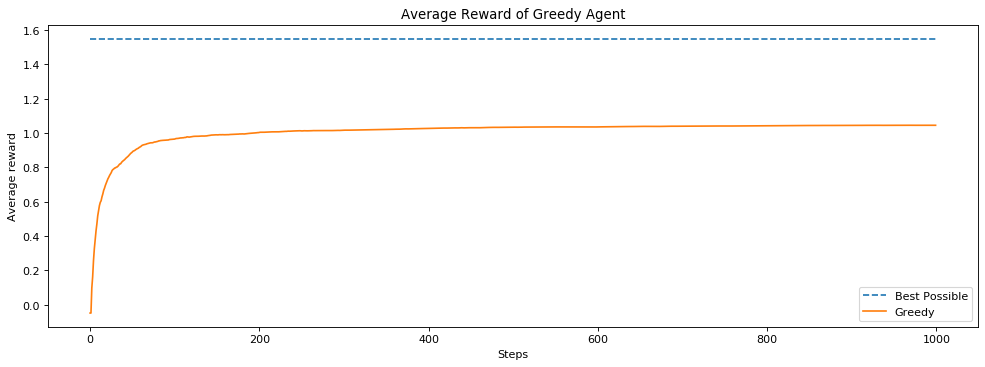

In [81]:
# Plot Greedy Result
num_runs = 200                    # The number of times we run the experiment
num_steps = 1000                  # The number of steps each experiment is run for
env = ten_arm_env.Environment     # We the environment to use
agent = GreedyAgent               # We choose what agent we want to use
agent_info = {"num_actions": 10}  # Pass the agent the information it needs; 
                                  # here it just needs the number of actions (number of arms).
env_info = {}                     # Pass the environment the information it needs; in this case, it is nothing.

all_averages = []

for i in tqdm(range(num_runs)):           # tqdm is what creates the progress bar below once the code is run
    rl_glue = RLGlue(env, agent)          # Creates a new RLGlue experiment with the env and agent we chose above
    rl_glue.rl_init(agent_info, env_info) # Pass RLGlue what it needs to initialize the agent and environment
    rl_glue.rl_start()                    # Start the experiment

    scores = [0]
    averages = []
    
    for i in range(num_steps):
        reward, _, action, _ = rl_glue.rl_step() # The environment and agent take a step and return
                                                 # the reward, and action taken.
        scores.append(scores[-1] + reward)
        averages.append(scores[-1] / (i + 1))
    all_averages.append(averages)

plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot([1.55 for _ in range(num_steps)], linestyle="--")
plt.plot(np.mean(all_averages, axis=0))
plt.legend(["Best Possible", "Greedy"])
plt.title("Average Reward of Greedy Agent")
plt.xlabel("Steps")
plt.ylabel("Average reward")
plt.show()
greedy_scores = np.mean(all_averages, axis=0)
np.save("greedy_scores", greedy_scores)